In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import torch
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
class CFG:
    epochs = 100
    batch_size = 32
    root_dir = '/kaggle/input/house-prices-advanced-regression-techniques'
    train_dir = os.path.join(root_dir, 'train.csv')
    test_dir = os.path.join(root_dir, 'test.csv')

In [3]:
train_df = pd.read_csv(CFG.train_dir)
print(train_df.info())
train_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [ ]:
test_df = pd.read_csv(CFG.test_dir)

print(test_df.info())
test_df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [6]:
train_ID = train_df['Id']
test_ID = test_df['Id']

train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

Top 10 Positive Correlations with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Top 10 Negative Correlations with SalePrice:
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


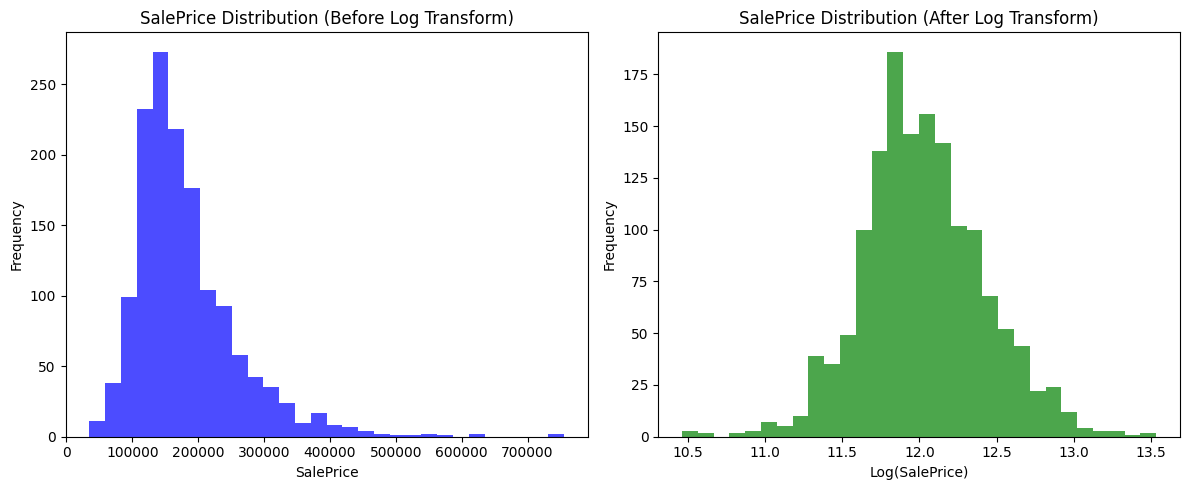

In [7]:
def eda(train_df):
    numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
    correlations = train_df[numeric_cols].corr()['SalePrice'].sort_values(ascending=False)
    top_10_positive = correlations[1:11]  
    top_10_negative = correlations[-10:]  
    
    print("Top 10 Positive Correlations with SalePrice:")
    print(top_10_positive)
    print("\nTop 10 Negative Correlations with SalePrice:")
    print(top_10_negative)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(train_df['SalePrice'], bins=30, color='blue', alpha=0.7)
    plt.title('SalePrice Distribution (Before Log Transform)')
    plt.xlabel('SalePrice')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(train_df['SalePrice']), bins=30, color='green', alpha=0.7)
    plt.title('SalePrice Distribution (After Log Transform)')
    plt.xlabel('Log(SalePrice)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

eda(train_df)

In [8]:
def features_engineering(df):
    cat_cols = [
        "Alley", "MiscFeature", "MasVnrType", "BsmtQual", "PoolQC", "Fence", "FireplaceQu", 
        "GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtCond", "BsmtExposure", 
        "BsmtFinType1", "BsmtFinType2"
    ]
    num_cols = ["GarageYrBlt", "MasVnrArea"]

    df[cat_cols] = df[cat_cols].fillna('None').applymap(str)
    df[num_cols] = df[num_cols].fillna(0)

    lot_features = ["LotFrontage", "LotArea", "LotShape", "TotalBsmtSF"]
    lot_shape_map = {"Reg": 3, "IR1": 2, "IR2": 1, "IR3": 0}
    df["LotShape"] = df["LotShape"].map(lot_shape_map)

    imputer = KNNImputer(n_neighbors=5)
    df["LotFrontage"] = imputer.fit_transform(df[lot_features])[:, 0]

    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[df.select_dtypes(include=["object"]).columns] = cat_imputer.fit_transform(df.select_dtypes(include=["object"]))

    missing_num_cols = [col for col in df.select_dtypes(exclude=["object"]).columns if col not in num_cols + ["LotFrontage"]]
    df[missing_num_cols] = imputer.fit_transform(df[missing_num_cols])

    print('NUMBER OF MISSING VALUES: ', df.isnull().sum().sum())

    return df

train_df = features_engineering(train_df)
test_df = features_engineering(test_df)

NUMBER OF MISSING VALUES:  0
NUMBER OF MISSING VALUES:  0


<ipython-input-8-84bf97bc9421>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cat_cols] = df[cat_cols].fillna('None').applymap(str)
<ipython-input-8-84bf97bc9421>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cat_cols] = df[cat_cols].fillna('None').applymap(str)


In [ ]:
neighborhood_quality = train_df.groupby('Neighborhood')['SalePrice'].agg(['mean', 'median', 'std']).reset_index()
neighborhood_quality.columns = ['Neighborhood', 'NeighborhoodMean', 'NeighborhoodMedian', 'NeighborhoodStd']

def add_features_engineering(df, neighborhood_quality=neighborhood_quality):
    numerical_features = df.select_dtypes(exclude=['object']).columns

    df['TotalUpBath'] = df['BsmtFullBath'] + df['FullBath']
    df['TotalBsmtBath'] = df['BsmtHalfBath'] + df['HalfBath']
    df['TotalBath'] = df['TotalUpBath'] + 0.5 * df['TotalBsmtBath']
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['Remodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['IsNew'] = (df['YrSold'] == df['YearBuilt']).astype(int)
    df['RecentRemodel'] = ((df['YrSold'] - df['YearRemodAdd']) <= 2).astype(int)
    df['Mid_old'] = ((df['YrSold'] - df['YearRemodAdd']) >= 3) & ((df['YrSold'] - df['YearRemodAdd']) <= 19).astype(int)
    df['Fairly_old'] = ((df['YrSold'] - df['YearRemodAdd']) >= 20) & ((df['YrSold'] - df['YearRemodAdd']) <= 49).astype(int)
    df['VeryOldHouse'] = (df['Age'] > 50).astype(int)

    df['OverallGrade'] = df['OverallQual'] * df['OverallCond']
    df['ExterGrade'] = df['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}) * \
                       df['ExterCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['KitchenScore'] = df['KitchenAbvGr'] * df['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['FireplaceScore'] = df['Fireplaces'] * df['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
    df['GarageScore'] = df['GarageCars'] * df['GarageQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})

    df['LivingAreaRatio'] = df['GrLivArea'] / df['LotArea']
    df['LotRatio'] = df['LotArea'] / df['LotFrontage']
    df['RoomDensity'] = df['TotRmsAbvGrd'] / df['GrLivArea']
    df['BasementRatio'] = df['TotalBsmtSF'] / df['1stFlrSF']
    df['PorchRatio'] = df['TotalPorchSF'] / df['GrLivArea']

    df = pd.merge(df, neighborhood_quality, on='Neighborhood', how='left')

    for col in ['NeighborhoodMean', 'NeighborhoodMedian', 'NeighborhoodStd']:
        df[col].fillna(df[col].median(), inplace=True)

    df['HasShed'] = df['MiscFeature'].apply(lambda x: 1 if x == 'Shed' else 0)
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['HasPorch'] = (df['TotalPorchSF'] > 0).astype(int)

    cluster_features = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'OverallQual']
    cluster_data = df[cluster_features].copy()
    
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['PriceCluster'] = kmeans.fit_predict(cluster_data_scaled)

    pca_features = [f for f in numerical_features if f not in ['Id', 'SalePrice'] and df[f].nunique() > 5]
    pca_data = df[pca_features].copy()
    
    scaler = StandardScaler()
    pca_data_scaled = scaler.fit_transform(pca_data)
    
    pca = PCA(n_components=5)
    pca_result = pca.fit_transform(pca_data_scaled)
    
    for i in range(5):
        df[f'PCA_{i+1}'] = pca_result[:, i]
    
    important_num_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt']
    for feature in important_num_features:
        df[f'{feature}_Sq'] = df[feature] ** 2
    
    df['OQ_GLA'] = df['OverallQual'] * df['GrLivArea']
    df['OQ_BSF'] = df['OverallQual'] * df['TotalBsmtSF']
    df['OQ_YB'] = df['OverallQual'] * df['YearBuilt']
    df['GLA_BSF'] = df['GrLivArea'] * df['TotalBsmtSF']
    df['OQ_NBH'] = df['OverallQual'] * df['NeighborhoodMean']

    numeric_feats = df.dtypes[df.dtypes != "object"].index
    numeric_feats = [feat for feat in numeric_feats if feat != 'SalePrice']

    skewed_feats = df[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
    skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
    print(f"There are {len(skewed_feats)} skewed numerical features to transform")

    pt = PowerTransformer(method='yeo-johnson')
    for feat in skewed_feats.index:
        if df[feat].nunique() <= 2:
            continue
        
        df[feat] = pt.fit_transform(df[[feat]])


    return df

train_df = add_features_engineering(train_df, neighborhood_quality)
test_df = add_features_engineering(test_df, neighborhood_quality)

<ipython-input-9-98d485d297b0>:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['RoomDensity'] = df['TotRmsAbvGrd'] / df['GrLivArea']
<ipython-input-9-98d485d297b0>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BasementRatio'] = df['TotalBsmtSF'] / df['1stFlrSF']
<ipython-input-9-98d485d297b0>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

There are 56 skewed numerical features to transform


<ipython-input-9-98d485d297b0>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BasementRatio'] = df['TotalBsmtSF'] / df['1stFlrSF']
<ipython-input-9-98d485d297b0>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PorchRatio'] = df['TotalPorchSF'] / df['GrLivArea']
<ipython-input-9-98d485d297b0>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the interm

There are 55 skewed numerical features to transform


In [ ]:
y = np.log1p(train_df['SalePrice'])

train_df.drop('SalePrice', axis=1, inplace=True)

categorical_cols = train_df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le



rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
lgb_model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)

voting_model = VotingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ]
)


voting_model.fit(train_df, y)

cv_scores = cross_val_score(voting_model, train_df, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")


predictions = voting_model.predict(test_df)
predictions = np.expm1(predictions)

submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8817
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 122
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8503
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 120
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [11]:
print(predictions)

[130630.50672973 196099.97820334 175278.61884642 ... 190763.26906356
 111461.93718507 205222.39660807]
